# Overall generic prescribing

The following chart shows that the proportion of prescriptions made generically has not dropped over the last 8 years; the proportion of spending which has been prescribed generically has dropped a lot more.

**Possible improvement**: we could exclude those marked in DM+D with `pres_statcd <> 1` as this supposedly identifies things that should not be prescribed generically.



In [5]:
sql = """WITH
  num AS (
  SELECT
    month,
    SUM(items) AS items,
    SUM(actual_cost) AS actual_cost
  FROM
    `ebmdatalab.hscic.normalised_prescribing_standard`
  WHERE
    bnf_code LIKE '_________AA%'
  GROUP BY
    month),
  denom AS (
  SELECT
    month,
    SUM(items) AS items,
    SUM(actual_cost) AS actual_cost
  FROM
    `ebmdatalab.hscic.normalised_prescribing_standard`
  --WHERE
  --  bnf_code LIKE '0%'
  GROUP BY
    month)
SELECT
  num.month,
  num.items / denom.items AS items_percent,
  num.actual_cost / denom.actual_cost AS act_cost_percent
FROM
  num
INNER JOIN
  denom
ON
  num.month = denom.month"""
top_df = pd.read_gbq(sql, 'ebmdatalab', verbose=False, dialect='standard')

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/io/gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)


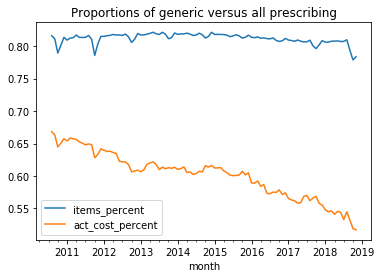

In [8]:
top_df = top_df.sort_values('month')
top_df.set_index('month').plot.line(title="Proportions of generic versus all prescribing")

# Example of how generic prescribing is supposed to work
Aripiprazole is a good example of a cat A product with lots of available AMPs.

It became Cat A in April 2015, and its price dropped rapidly, settling around May 2017, and it was nearly always prescribed generically, so cost savings accrued automatically.

In [25]:
sql = """WITH
      num AS (
      SELECT
        month,
        SUBSTR(bnf_code, 0, 9) AS product,
        SUM(items) AS items
      FROM
        `ebmdatalab.hscic.normalised_prescribing_standard`
      WHERE
        bnf_code LIKE '0402010ADAA%'
      GROUP BY
        month,
        product),
      denom AS (
      SELECT
        month,
        SUBSTR(bnf_code, 0, 9) AS product,
        SUM(items) AS items,
        SUM(net_cost)/SUM(quantity) AS cost_per_quantity
      FROM
        `ebmdatalab.hscic.normalised_prescribing_standard`
      WHERE
        bnf_code LIKE '0402010AD%'
      GROUP BY
        month,
        product),
      data AS (
      SELECT
        num.month,
        num.product,
        num.items / denom.items AS value,
        denom.items AS items,
        denom.cost_per_quantity 
      FROM
        num
      INNER JOIN
        denom
      ON
        num.month = denom.month
        AND num.product = denom.product )
    SELECT
      bnf.chemical AS product_name,
      data.*
    FROM
      data
    INNER JOIN 
      (SELECT DISTINCT chemical, chemical_code FROM `ebmdatalab.hscic.bnf`) bnf 
    ON
      bnf.chemical_code = data.product"""
ar_df = pd.read_gbq(sql, 'ebmdatalab', verbose=False, dialect='standard')

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/io/gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)


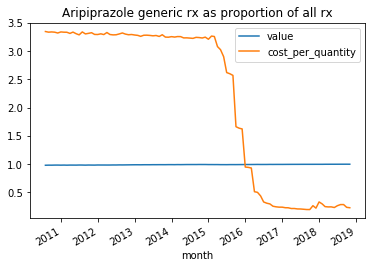

In [26]:
ar_df.set_index('month')[['value', 'cost_per_quantity']].plot.line(title="Aripiprazole generic rx as proportion of all rx")

# Captopril - another example of how it's meant to work
This was Cat M until March 2014, then Cat A (and still is)

In [ ]:
sql = """WITH
      num AS (
      SELECT
        month,
        SUBSTR(bnf_code, 0, 9) AS product,
        SUM(items) AS items
      FROM
        `ebmdatalab.hscic.normalised_prescribing_standard`
      WHERE
        bnf_code LIKE '0205051F0AA%'
      GROUP BY
        month,
        product),
      denom AS (
      SELECT
        month,
        SUBSTR(bnf_code, 0, 9) AS product,
        SUM(items) AS items,
        SUM(net_cost)/SUM(quantity) AS cost_per_quantity
      FROM
        `ebmdatalab.hscic.normalised_prescribing_standard`
      WHERE
        bnf_code LIKE '0205051F0%'
      GROUP BY
        month,
        product),
      data AS (
      SELECT
        num.month,
        num.product,
        num.items / denom.items AS value,
        denom.items AS items,
        denom.cost_per_quantity 
      FROM
        num
      INNER JOIN
        denom
      ON
        num.month = denom.month
        AND num.product = denom.product )
    SELECT
      bnf.chemical AS product_name,
      data.*
    FROM
      data
    INNER JOIN 
      (SELECT DISTINCT chemical, chemical_code FROM `ebmdatalab.hscic.bnf`) bnf 
    ON
      bnf.chemical_code = data.product"""
cap_df = pd.read_gbq(sql, 'ebmdatalab', verbose=False, dialect='standard')

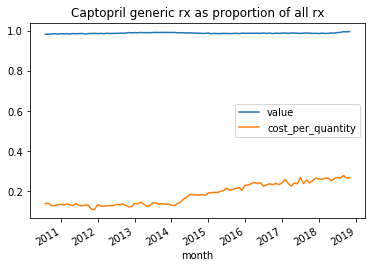

In [29]:
# Captopril was Cat M until March 2014, then Cat A
cap_df.set_index('month')[['value', 'cost_per_quantity']].plot.line(title="Captopril generic rx as proportion of all rx")

# Which are the chemicals showing the greatest positive and negative changes?

In [73]:
import pandas as pd
filename = 'generic_ratios_by_chemical_4.csv'
try:
    df = pd.read_csv(filename)
except IOError:
    sql = """WITH
      num AS (
      SELECT
        month,
        SUBSTR(bnf_code, 0, 9) AS product,
        SUM(items) AS items
      FROM
        `ebmdatalab.hscic.normalised_prescribing_standard`
      WHERE
        bnf_code LIKE '_________AA%'
      GROUP BY
        month,
        product),
      denom AS (
      SELECT
        month,
        SUBSTR(bnf_code, 0, 9) AS product,
        SUM(items) AS items
      FROM
        `ebmdatalab.hscic.normalised_prescribing_standard`
      GROUP BY
        month,
        product),
      data AS (
      SELECT
        num.month,
        num.product,
        num.items / denom.items AS value,
        denom.items AS items
      FROM
        num
      INNER JOIN
        denom
      ON
        num.month = denom.month
        AND num.product = denom.product ),
      data_with_stats AS (
      SELECT
        DISTINCT month,
        product,
        value,
        data.items AS total_items,
        LAST_VALUE(value) OVER (PARTITION BY product ORDER BY month ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) - FIRST_VALUE(value) OVER (PARTITION BY product ORDER BY month ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS delta,
        ABS(PERCENTILE_CONT(value,
            0.75) OVER (PARTITION BY product) - PERCENTILE_CONT(value,
            0.25) OVER (PARTITION BY product)) AS iqr
      FROM
        data )
    SELECT
      bnf.chemical AS product_name,
      data_with_stats.*
    FROM
      data_with_stats
    INNER JOIN 
      (SELECT DISTINCT chemical, chemical_code FROM `ebmdatalab.hscic.bnf`) bnf 
    ON
      bnf.chemical_code = data_with_stats.product
      """
    df = pd.read_gbq(sql, 'ebmdatalab', verbose=False, dialect='standard')
    df.to_csv(filename)

In [26]:
most_variance = df.groupby('product').min().reset_index()
most_variance = most_variance[most_variance.total_items > 10000].sort_values('iqr', ascending=False).head(50)

In [27]:
most_variance

,product,product_name,month,value,total_items,delta,iqr
1933,1404000L0,Pneumococcal,2010-08-01,0.000174,14903,0.996960,0.985695
1716,1302011M0,Liquid Paraffin,2010-08-01,0.017774,13278,-0.580362,0.463628
712,0411000F0,Galantamine,2010-08-01,0.365902,13849,-0.557149,0.453641
1714,130201100,Emollient Bath & Shower Preparations,2010-08-01,0.271655,79653,-0.495990,0.355600
659,0408010Q0,Phenytoin Sodium,2010-08-01,0.645750,55969,0.351176,0.342271
362,0302000K0,Budesonide,2010-08-01,0.143771,257502,-0.379180,0.275971
642,0408010AE,Pregabalin,2010-08-01,0.546930,140772,-0.017969,0.275875
1556,1106000AD,Latanoprost & Timolol,2010-08-01,0.500683,23484,0.381675,0.263378
602,0407020AD,Oxycodone Hydrochloride,2010-08-01,0.308518,72685,-0.313963,0.246140
600,0407020A0,Fentanyl,2010-08-01,0.204811,77476,-0.478421,0.245871


# Chemicals being prescribed more and more as generics

In general, there are two questions to ask about these:

1. Why were they not already being prescribed as generics?
2. What is driving the change?

Generally, things are not prescribed as generics  because:


* it is officially not recommended (for example, things which come in radically different strengths but the format is similar (patches, opioids), things which work differently despite being equivalent at VMP level (modified-release stuff, things with narrow therapeutic index, things which come with devices (viz inhalers, syringes)), things with narrow therapeutic index / bioavailability variance, things which a different within generic class (e.g. skin preparations containing paraffin, foods)
* it is avoided for similar, non-official reasons (opthamologists prescribing eye drops by brand because the bottle is more squeezy)
* because people are wary of prescribing generically because they're easy to confuse (this is common with contraceptive pills)
* because people just don't know the generic names (more common with combination products, products with long names)

Just two of the things below are not in the class "should not substitute generically" (phenytoin, salbutamol); in these cases we should ask why they are increasingly being prescribed generically.  All the others it was always OK for them to be prescribed generically, so why weren't they?




/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


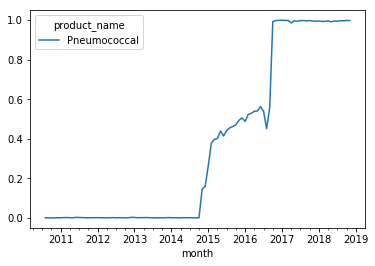

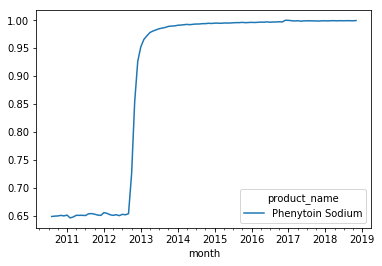

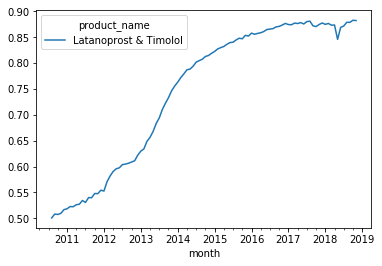

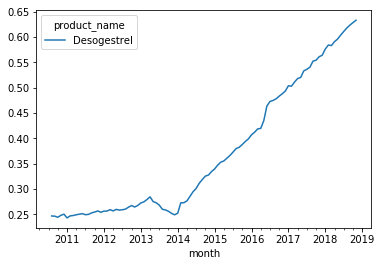

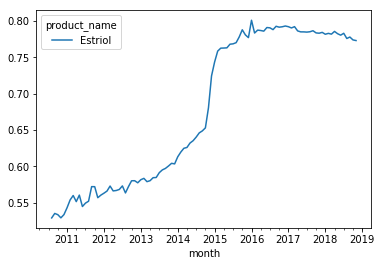

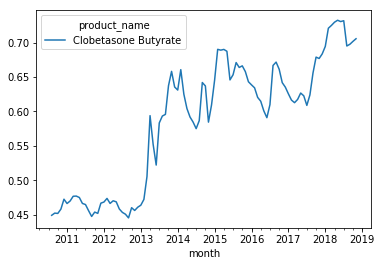

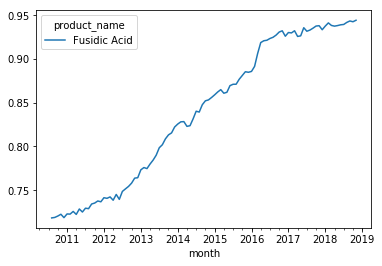

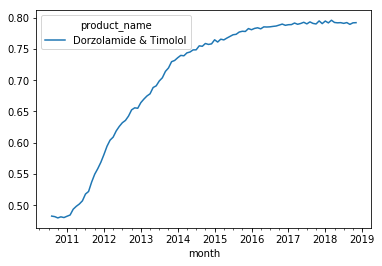

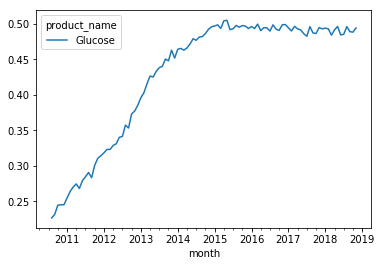

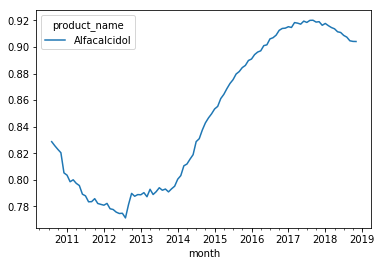

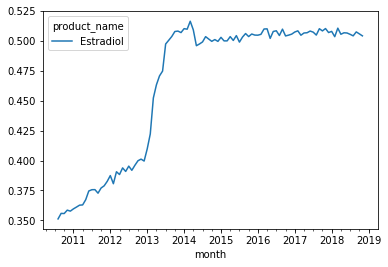

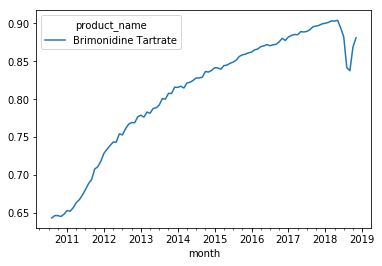

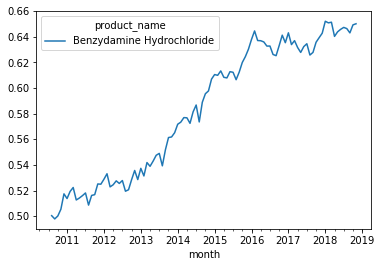

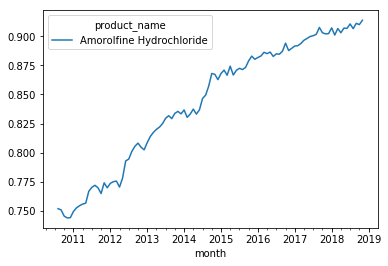

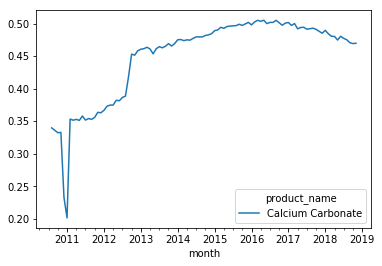

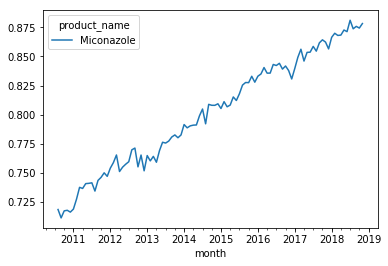

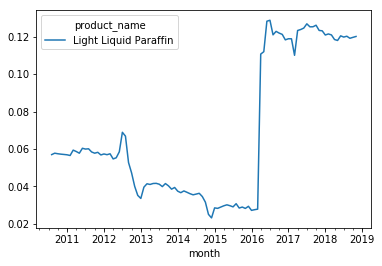

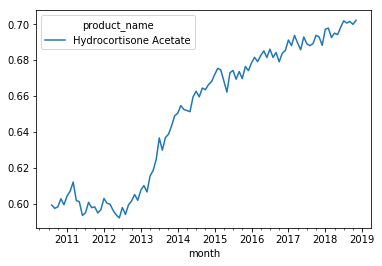

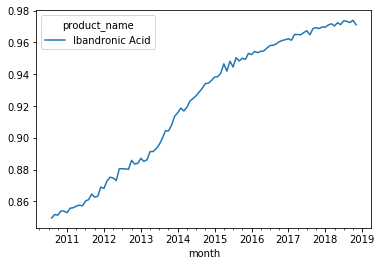

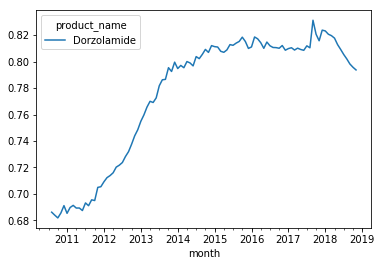

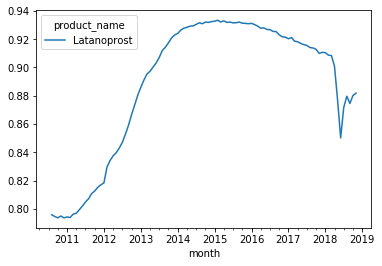

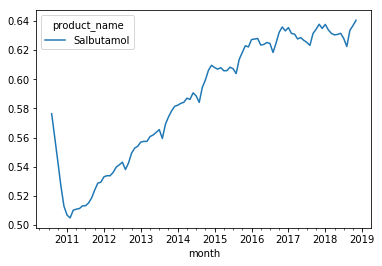

In [28]:
%matplotlib inline
for product in most_variance[most_variance['delta'] > 0]['product']:
    df[df['product'] == product].groupby(['month', 'product_name']).sum().value.unstack().plot.line()


# Chemicals being prescribed less and less as generics

Many of these are classified as things that shouldn't be prescribed generically, e.g. enoxaparin, budesonide, oxycodone. Of these, a large number are MR formulations. In these cases, it would be interesting to know:

1. When the recommendation came about for this to happen
2. How the recommendation was disseminated
3. In the case of MR formulations, why and when were they introduced. 



There are more which are not subject to the "shouldn't be prescribed genericaly" rule though, such as galantamine, ibuprofen, exanatide, Isosorbide mononitrate, venlafaxine, tolterodine, quetiapine. Most of these appear to be MR formulations.  Isosorbide mononitrate is a good example.

* Tolterodine's change is from [one 4mg presentation](https://openprescribing.net/ccg/99P/0704020N0BFAAAC/price_per_unit/?date=2018-11-01) which has many branded generics, which are MR
* Galantamine has many branded generics ([example](https://openprescribing.net/ccg/99P/0411000F0BFACAG/price_per_unit/?date=2018-11-01), which are MR
* Ibuprofen largely accounted for by PPU-style savings to the Fenbid brand gel. This is Category C, and the reference brand is Ibugel Forte for the 100g pack. There are [several branded generics](https://openprescribing.net/ccg/99P/1003020P0AAAIAI/price_per_unit/?date=2018-11-01) and (possibly) only one true generic available (not sure I'm interpreting that data correctly)
* Exentatide's overall prescribing has dropped; its generic prescribing has dropped by much more than its branded (mostly Bydureon). It appears that the [brand]((https://openprescribing.net/ccg/99P/0601023Y0AAADAD/price_per_unit/?date=2018-11-01)) is a "prolonged release" injection 
* Isosorbide Mononitrate is due to a large number of branded generics. Most of it is for [the MR 60mg tab](https://openprescribing.net/dmd/vmp/319136004/relationships/) which has a [wide range of prices for the tab and the cap](https://openprescribing.net/ccg/99P/0206010K0AAAEAE/price_per_unit/?date=2018-11-01)).  What's interesting here is that non-MR is available in 10, 20 and 40; whereas MR is available in 25, 40, 50,and 60.  There are literally *no* branded generics for the non-MR version (there [used to be](https://openprescribing.net/dmd/vmp/319135000/relationships/) but these have no prescribing any more).

However, it is also the case that **not every** high-volume presentation that has a MR equivalent has a preponderance of branded generics available. For example, `Nitrofurantoin_Cap 100mg M/R`, `Gliclazide_Tab 30mg M/R`, and `Tamsulosin HCl_Cap 400mcg M/R` are overwhelmingly prescsribed generically, whereas `Morph Sulf_Cap 10mg M/R` is not.  That said, the mean generic rx percentage for MR formulations is 56%, against the 85% of all drugs.

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


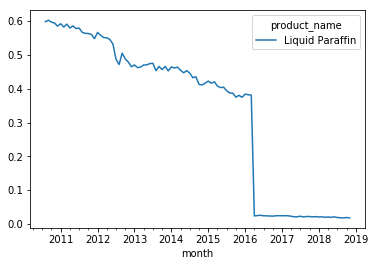

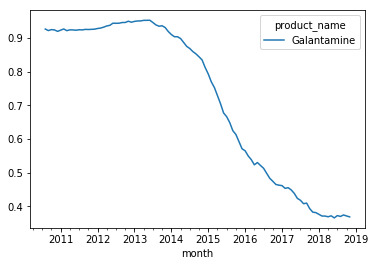

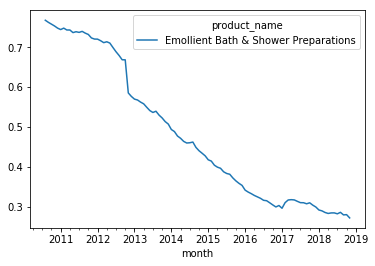

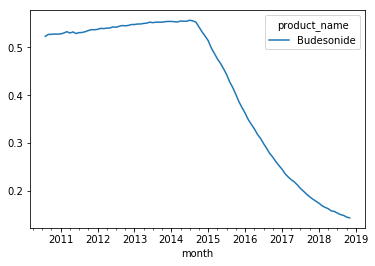

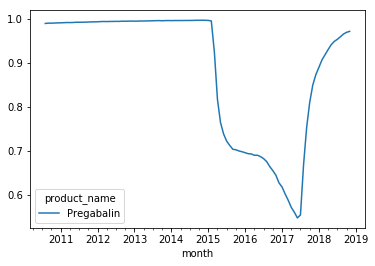

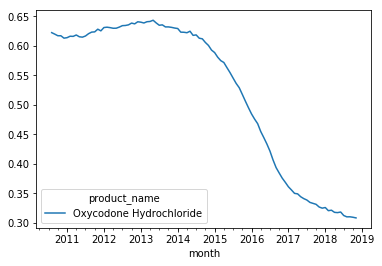

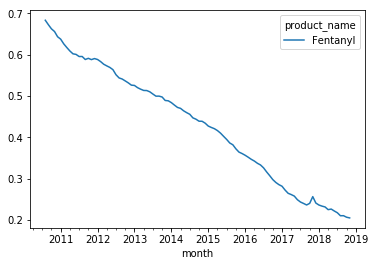

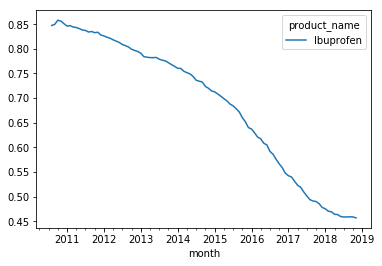

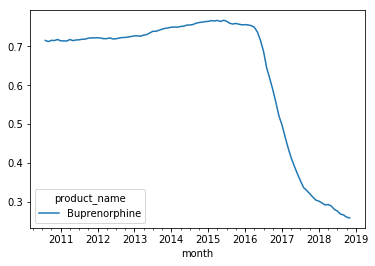

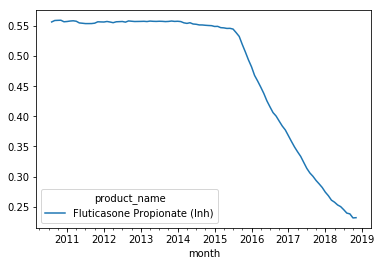

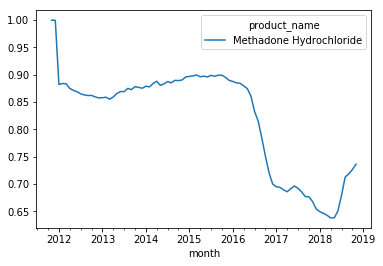

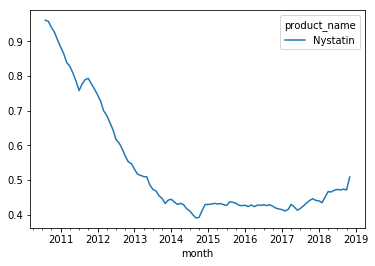

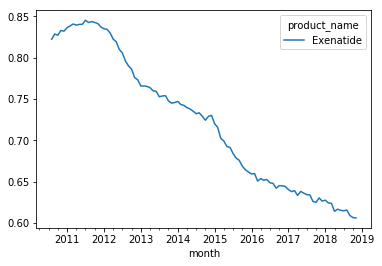

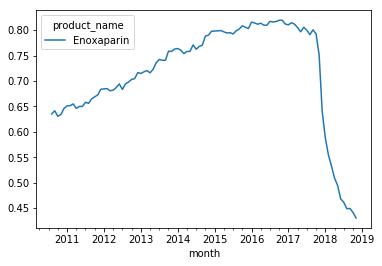

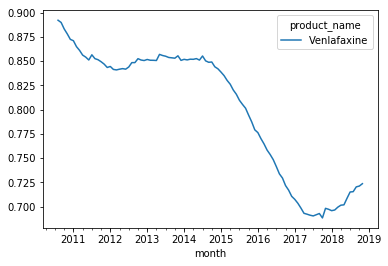

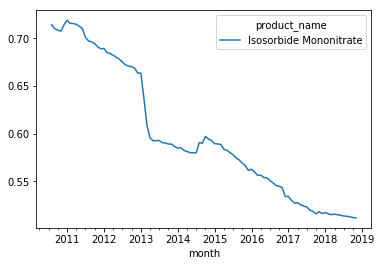

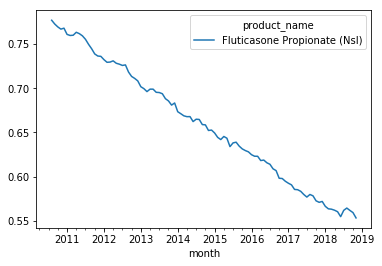

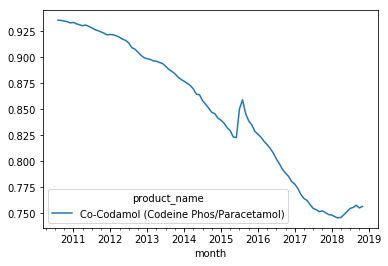

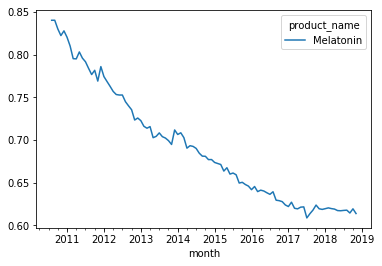

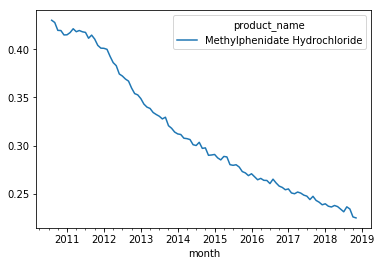

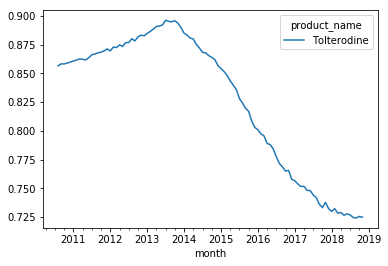

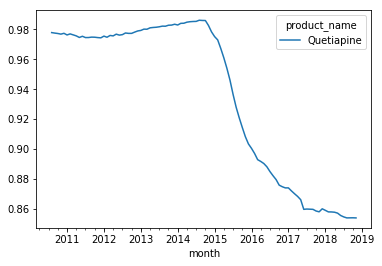

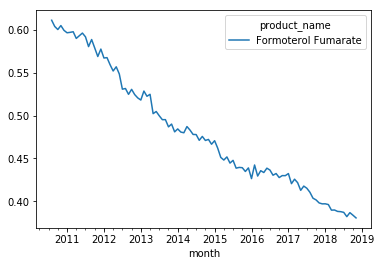

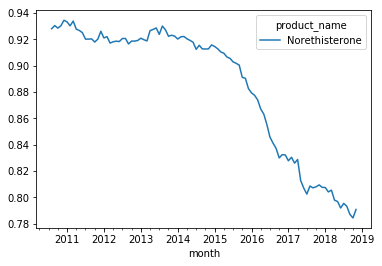

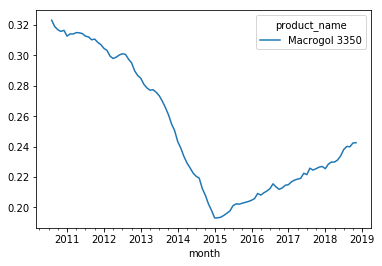

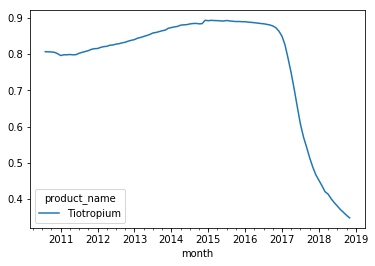

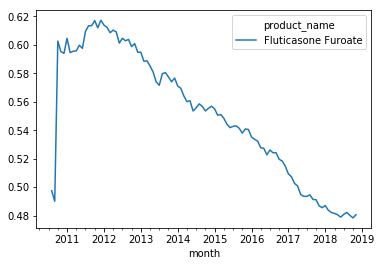

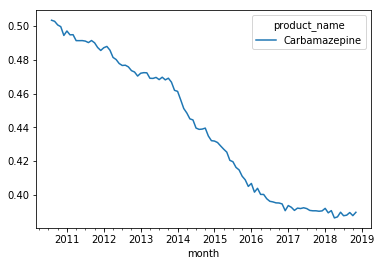

In [29]:
%matplotlib inline
for product in most_variance[most_variance['delta'] < 0]['product']:
    df[df['product'] == product].groupby(['month', 'product_name']).sum().value.unstack().plot.line()


## What can we say about modified-release?

It's certainly a category that is increasing over time, and it always goes in Cat C (as it's not readily available as a generic)

In [52]:
sql = """SELECT
  date,
  tariff_category,
  COUNT(*) AS count
FROM
  `ebmdatalab.dmd.dt_viewer`
WHERE
  vmpp LIKE '%odified%'
GROUP BY
  date, tariff_category
ORDER BY
  date"""
df = pd.read_gbq(sql, 'ebmdatalab', verbose=False, dialect='standard')

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/io/gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)


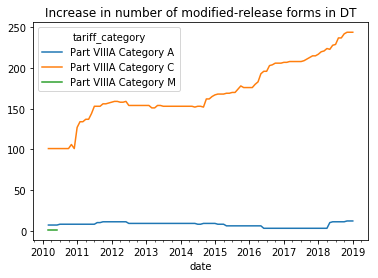

In [68]:
df.set_index('date').groupby(['date','tariff_category']).sum()['count'].unstack().plot.line(title="Increase in number of modified-release forms in DT")

## What proportion of MR formulations are rxed generically?

Answer: 56%

In [30]:
sql = """WITH
  mr AS (
  SELECT
    DISTINCT vmpp,
    bnf_code,
    CONCAT(SUBSTR(bnf_code, 0, 9), 'AA%', SUBSTR(bnf_code, 14, 15)) AS generic_wildcard,
    CONCAT(SUBSTR(bnf_code, 0, 9), '%', SUBSTR(bnf_code, 14, 15)) AS presentation_wildcard
  FROM
    dmd.dt_viewer
  WHERE
    vmpp LIKE '%modified%'
    AND bnf_code IS NOT NULL),
  num AS (
  SELECT
    month,
    presentation_wildcard,
    SUM(items) AS items
  FROM
    `ebmdatalab.hscic.prescribing_2018_11` rx
  INNER JOIN
    mr
  ON
    rx.bnf_code LIKE mr.generic_wildcard
  GROUP BY
    month,
    presentation_wildcard),
  denom AS (
  SELECT
    month,
    presentation_wildcard,
    SUM(items) AS items,
    SUM(net_cost)/SUM(quantity) AS cost_per_quantity
  FROM
    `ebmdatalab.hscic.prescribing_2018_11` rx
  INNER JOIN
    mr
  ON
    rx.bnf_code LIKE mr.presentation_wildcard
  GROUP BY
    month,
    presentation_wildcard),
  data AS (
  SELECT
    num.month,
    num.presentation_wildcard,
    num.items / denom.items AS value,
    denom.items AS items,
    denom.cost_per_quantity
  FROM
    num
  INNER JOIN
    denom
  ON
    num.month = denom.month
    AND num.presentation_wildcard = denom.presentation_wildcard )
SELECT
  bnf.presentation,
  data.*
FROM
  data
INNER JOIN
  `ebmdatalab.hscic.bnf` bnf
ON
  bnf.presentation_code LIKE data.presentation_wildcard
  AND bnf.presentation_code LIKE '_________AA%'
ORDER BY
  value"""
df = pd.read_gbq(sql, 'ebmdatalab', verbose=False, dialect='standard')

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/io/gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)


In [31]:
df.head(3)

,presentation,month,presentation_wildcard,value,items,cost_per_quantity
0,Methylphenidate HCl_Cap 30mg M/R,2018-11-01,0404000M0%AV,0.036364,9680,1.153408
1,Methylphenidate HCl_Cap 20mg M/R,2018-11-01,0404000M0%AQ,0.040742,10137,0.986718
2,Methylphenidate HCl_Cap 10mg M/R,2018-11-01,0404000M0%AU,0.048777,6253,0.818243


In [32]:
df.tail(3)

,presentation,month,presentation_wildcard,value,items,cost_per_quantity
221,Ranolazine_Tab 750mg M/R,2018-11-01,0206030Z0%AC,0.993385,4989,0.816321
222,Fusidic Acid_Viscous Eye Dps 1%,2018-11-01,1103010H0%AA,0.997328,8235,5.810917
223,Indometacin_Cap 75mg M/R,2018-11-01,1001010K0%AD,1.000000,541,0.086480


In [72]:
df['value'].describe()

count    224.000000
mean       0.555679
std        0.336104
min        0.036364
25%        0.202221
50%        0.571208
75%        0.907623
max        1.000000
Name: value, dtype: float64

## Let's break down some of these MR products by CCG

It looks like most CCGs are remarkably responsive to these becoming available, and there is no variance by EPS software

In [1]:
# galantamine
import pandas as pd
sql = """WITH
      num AS (
      SELECT
        month,
        pct,
        SUM(items) AS items
      FROM
        `ebmdatalab.hscic.normalised_prescribing_standard`
      WHERE
        bnf_code LIKE '0411000F0AA__AG'
      GROUP BY
        month,
        pct),
      denom AS (
      SELECT
        month,
        pct,
        SUM(items) AS items
      FROM
        `ebmdatalab.hscic.normalised_prescribing_standard`
      WHERE
        bnf_code LIKE '0411000F0____AG'
      GROUP BY
        month,
        pct)
      SELECT
        num.month,
        num.pct,
        num.items / denom.items AS value,
        denom.items AS items
      FROM
        num
      INNER JOIN
        denom
      ON
        num.month = denom.month
        AND num.pct = denom.pct 
      """
df_galnt = pd.read_gbq(sql, 'ebmdatalab', verbose=False, dialect='standard')
    
#df[df['product_name'].str.contains("Methylphe")].groupby(['month', 'product_name']).sum().value.unstack().plot.line()

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/io/gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)


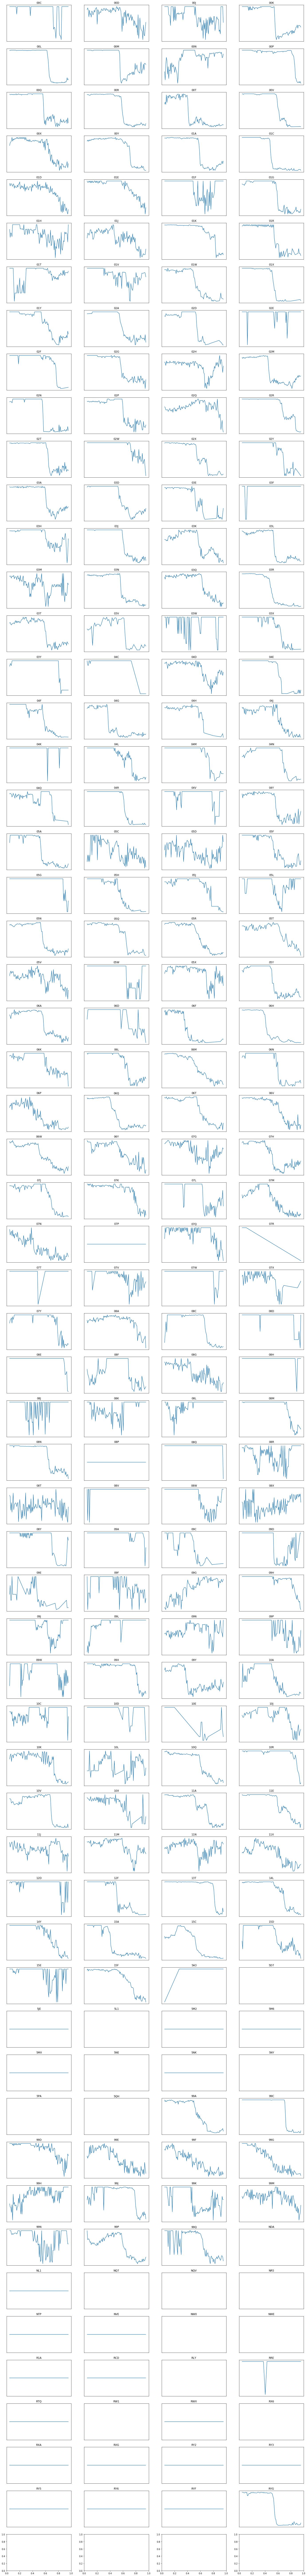

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
grouped = list(df_galnt.groupby('pct'))
ncols = 4
nrows = int(len(grouped) / ncols) + 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))

for i, (k, grp) in enumerate(grouped):
    col = int(i % ncols) 
    row = int(i / ncols) 
    grp.set_index('month')['value'].plot.line(title=k, ax=axes[row, col])
    axes[row, col].xaxis.set_visible(False)
    axes[row, col].yaxis.set_visible(False)
#df_galnt.groupby(['month', 'pct']).plot.line()

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/io/gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)


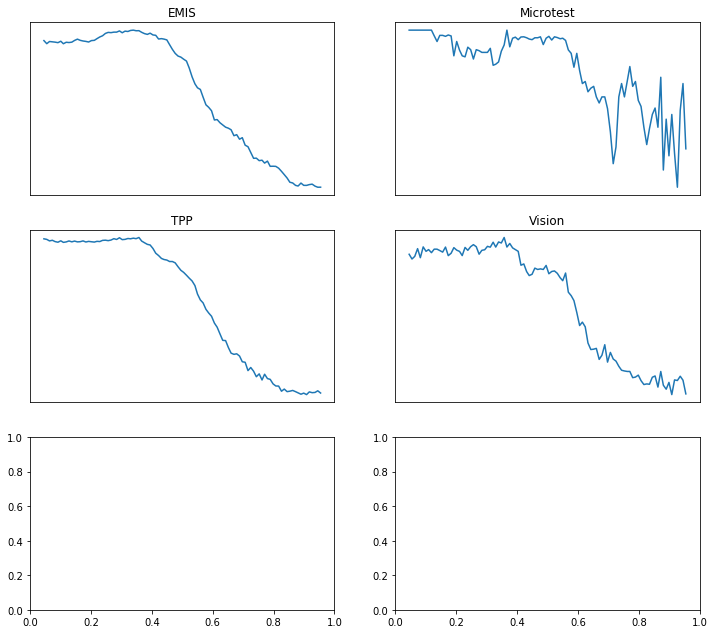

In [23]:
# same, diced by software

sql="""WITH
  software AS (
      SELECT string_field_0 AS practice_id,
      string_field_12 AS software_id
    FROM hscic.gpsoc_marketshare),

      num AS (
      SELECT
        month,
        software_id,
        SUM(items) AS items
      FROM
        `ebmdatalab.hscic.normalised_prescribing_standard` rx
      INNER JOIN software on software.practice_id = rx.practice
      WHERE
        bnf_code LIKE '0411000F0AA__AG'
      GROUP BY
        month,
        software_id),
      denom AS (
      SELECT
        month,
        software_id,
        SUM(items) AS items
      FROM
        `ebmdatalab.hscic.normalised_prescribing_standard` rx
      INNER JOIN software on software.practice_id = rx.practice
      WHERE
        bnf_code LIKE '0411000F0____AG'
      GROUP BY
        month,
        software_id)
      SELECT
        num.month,
        num.software_id,
        num.items / denom.items AS value,
        denom.items AS items
      FROM
        num
      INNER JOIN
        denom
      ON
        num.month = denom.month
        AND num.software_id = denom.software_id"""
df2 = pd.read_gbq(sql, 'ebmdatalab', verbose=False, dialect='standard')
grouped = list(df2.groupby('software_id'))
ncols = 2
nrows = int(len(grouped) / ncols) + 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))

for i, (k, grp) in enumerate(grouped):
    col = int(i % ncols) 
    row = int(i / ncols) 
    grp.set_index('month')['value'].plot.line(title=k, ax=axes[row, col])
    axes[row, col].xaxis.set_visible(False)
    axes[row, col].yaxis.set_visible(False)